In [513]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from imblearn.over_sampling import SMOTE

In [397]:
#Importing csv files with encoding
user_engagement=pd.read_csv('/Users/shilpasingla/Data Science/TensorIot/takehome_user_engagement.csv')
user=pd.read_csv('/Users/shilpasingla/Data Science/TensorIot/takehome_users.csv',encoding='latin-1')

In [398]:
user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [399]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [400]:
user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1.0,1.0
1,2013-11-15 03:45:04,2.0,1.0
2,2013-11-29 03:45:04,2.0,1.0
3,2013-12-09 03:45:04,2.0,1.0
4,2013-12-25 03:45:04,2.0,1.0


In [401]:
user_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134897 entries, 0 to 134896
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   time_stamp  134897 non-null  object 
 1   user_id     134896 non-null  float64
 2   visited     134896 non-null  float64
dtypes: float64(2), object(1)
memory usage: 3.1+ MB


In [402]:
#There is one extra time_stamp with no info about user_id or visited so we will remove that
#Also changing dtype for column user_id as int
user_engagement=user_engagement.drop(index=134896)
user_engagement['user_id']=user_engagement.user_id.astype('int64')


In [403]:
## Exploratory Data Analysis
# No of users in each table
print('Unique Users in User Engagement Table :',len(user_engagement.user_id.unique()))
print('Unique Users in User Table :',len(user.object_id.unique()))

Unique Users in User Engagement Table : 5609
Unique Users in User Table : 12000


In [404]:
#User Engagement table has less Users log compare to total user data

In [405]:
# Date columns in users and usersengagement table to be converted to appropriate format of datetime
user_engagement['time_stamp']=pd.to_datetime(user_engagement['time_stamp'],format='%Y-%m-%d %H:%M:%S')
user['creation_time']=pd.to_datetime(user['creation_time'],format='%Y-%m-%d %H:%M:%S')
user['last_session_creation_time']=pd.to_datetime(user['last_session_creation_time'],format='%Y-%m-%d %H:%M:%S')

#### Determing the 'Adoptive users' using visits and logs in user engagement table

In [406]:
# For each users we check difference in two consecutive date log by .diff function and since every first date 
#diff will be na so we fill it with 0 days

#For each user id if sum of any two consecutive date difference is less than equal to 7,means that users has visited
#atleast 3 times between any 7 days window so that user is asumed to be adoptive user
user_engagement['time_diff'] = user_engagement.groupby('user_id')['time_stamp'].diff().fillna(pd.Timedelta(days=0))
user_engagement['visit_days_count']=user_engagement.groupby('user_id')['time_diff'].shift(-1)+user_engagement['time_diff']
adopted_users = user_engagement[user_engagement['visit_days_count'] <= timedelta(days=7)]['user_id'].unique()
print(adopted_users)
print('Total No of Adopted Users :',len(adopted_users))


[   2   10   19 ... 7682 7683 7688]
Total No of Adopted Users : 1222


In [407]:
user_engagement.drop(columns=['time_diff','visit_days_count'],inplace=True)

In [408]:
# In user table we can add a column of adopted users if object_id exist in newly fetched adopted_user array
user['adopted_users']=user.object_id.apply(lambda x:1 if x in adopted_users else 0 )

In [409]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
 10  adopted_users               12000 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(5), object(3)


In [410]:
user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_users
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.398138810,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1970-01-01 00:00:01.396237504,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1970-01-01 00:00:01.363734892,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.369210168,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.358849660,0,0,193,5240.0,0


#### Now since we have got adopted users in user table we can do univariate,bivariate analysis


In [440]:
# Creation Source

In [429]:
def get_percentage(column_name):
    temp_df=user.groupby([column_name])['adopted_users'].agg(['sum','count']).reset_index()
    temp_df.rename(columns={'sum':'Sum_Val','count':'Count_Val'},inplace=True)
    temp_df['per']=temp_df.apply(lambda x: x['Sum_Val']*100/x['Count_Val'],axis=1)
    temp_df = temp_df.sort_values(by='per',ascending=False)
    return temp_df

In [431]:
df_creation_source=get_percentage('creation_source')

In [432]:
df_creation_source

,creation_source,Sum_Val,Count_Val,per
0,GUEST_INVITE,275,2163,12.713823
4,SIGNUP_GOOGLE_AUTH,176,1385,12.707581
3,SIGNUP,222,2087,10.637278
1,ORG_INVITE,419,4254,9.849553
2,PERSONAL_PROJECTS,130,2111,6.158219


<AxesSubplot: xlabel='creation_source', ylabel='adopted_users'>

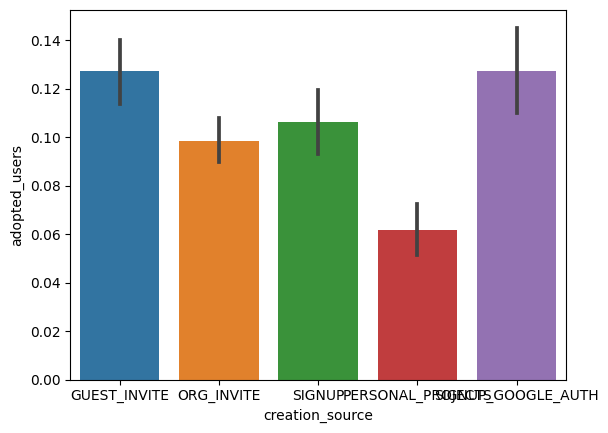

In [456]:
# conclusion - %age of adopted users is highest in case of Guest_Invite & SIGNUP_GOOGLE_AUTH
sns.barplot(x='creation_source',y='adopted_users',data=user)

In [442]:
# opted_in_to_mailing_list

In [447]:
df_opted_mailing=get_percentage('opted_in_to_mailing_list')

In [457]:
# Conclusion -There is not much difference b/w %age of adopted users opting for in mailing list to not opting for the same
df_opted_mailing

,opted_in_to_mailing_list,Sum_Val,Count_Val,per
1,1,331,2994,11.055444
0,0,891,9006,9.893404


<AxesSubplot: xlabel='opted_in_to_mailing_list', ylabel='adopted_users'>

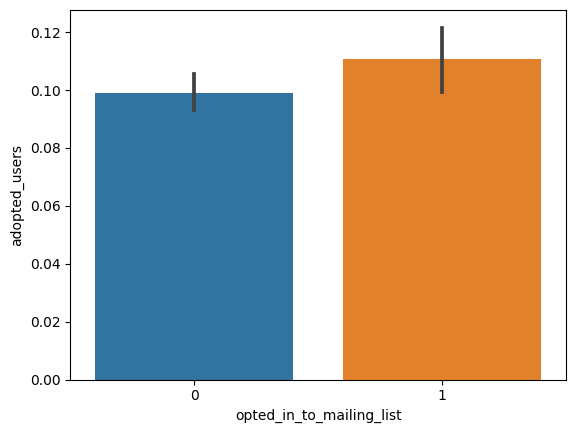

In [458]:
sns.barplot(x='opted_in_to_mailing_list',y='adopted_users',data=user)

In [449]:
#enabled_for_marketing_drip

In [450]:
df_marketing_drip=get_percentage('enabled_for_marketing_drip')

In [459]:
#Conclusion - There is not much difference b/w %age of adopted users enabled for marketing drip to not opting for the same
df_marketing_drip

,enabled_for_marketing_drip,Sum_Val,Count_Val,per
1,1,195,1792,10.881696
0,0,1027,10208,10.060737


In [453]:
# org_id

In [454]:
df_org=get_percentage('org_id')

In [460]:
# conclusion - few org_ids like 225,235.. have high adoption rate. This variable thus creates impact
df_org

,org_id,Sum_Val,Count_Val,per
225,225,7,17,41.176471
235,235,5,13,38.461538
364,364,4,11,36.363636
139,139,7,21,33.333333
381,381,4,12,33.333333
...,...,...,...,...
237,237,0,18,0.000000
223,223,0,19,0.000000
396,396,0,9,0.000000
397,397,0,8,0.000000


In [441]:
#Invited by user id

In [425]:
#To check how many adopted users are invited by user id ,since we have null in this column so we can fill with -1 and create a user_referal column
user['invited_by_user_id']=user.invited_by_user_id.fillna(-1)
user['user_referral'] = user.invited_by_user_id.apply(lambda x: 0 if x==-1 else 1)
user=user.drop(columns=['invited_by_user_id'])

In [426]:
user_referral=get_percentage('user_referral')

In [427]:
user_referral

,user_referral,Sum_Val,Count_Val,per
1,1,694,6417,10.815023
0,0,528,5583,9.457281


<AxesSubplot: xlabel='user_referral', ylabel='adopted_users'>

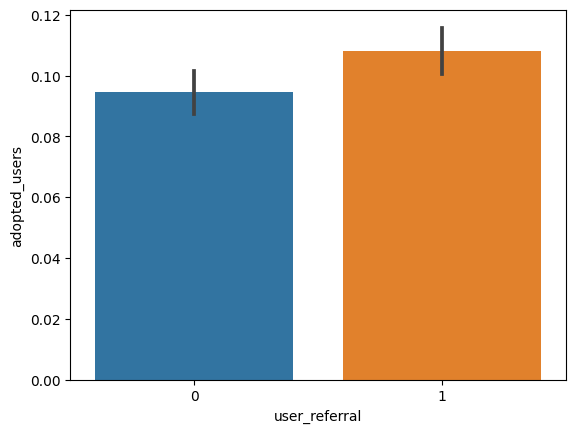

In [461]:
# Conclusion - %age of users refered by user_id is almost similar to non refereal in case of adopted users
sns.barplot(x='user_referral',y='adopted_users',data=user)

In [ ]:
# for col in ['','']:
#     g=sns.FacetGrid(df_users,hue='adopted_user',height=3,aspect=1.5)
#     g.map(plt.hist,col,alpha=0.5,bins=20)
#     g.add_legend()

In [502]:
#Preparing data for the model
#checking if y variable is balanced or not 

In [503]:
#Definig X and Y variables for the model
y=user['adopted_users']
x=user[['creation_source','opted_in_to_mailing_list','enabled_for_marketing_drip','org_id','user_referral']]

In [504]:
#This shows data is not balanced
y.value_counts()

0    10778
1     1222
Name: adopted_users, dtype: int64

In [506]:
#create dummy varoables for 
X_df=pd.get_dummies(x,drop_first=True)

In [507]:
x_train,x_test,y_train,y_test=train_test_split(X_df,y,test_size=0.3,random_state=123)

In [508]:
y_train.value_counts()

0    7568
1     832
Name: adopted_users, dtype: int64

In [509]:
from imblearn.over_sampling import SMOTE

In [514]:
sm=SMOTE(random_state=123)

In [515]:
x_smote_train,y_smote_train=sm.fit_resample(x_train,y_train)

In [544]:
params_grid={'n_estimators':[40,50,60],
            'max_depth':[19,20,21]}

In [545]:
#Tuning the model
rf=GridSearchCV(RandomForestClassifier(),params_grid,cv=10,verbose=1,n_jobs=-1)
rf.fit(x_smote_train,y_smote_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [19, 20, 21, 22],
                         'n_estimators': [30, 40, 50, 60]},
             verbose=1)

In [546]:
rf.best_params_

{'max_depth': 20, 'n_estimators': 50}

In [547]:
rf.best_score_

0.8296150666046183

In [560]:
model=RandomForestClassifier(n_estimators=50,max_depth=20,verbose=1,n_jobs=-1)
model.fit(x_smote_train,y_smote_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished


RandomForestClassifier(max_depth=20, n_estimators=50, n_jobs=-1, verbose=1)

In [561]:
ypred=rf.predict(x_test)

In [562]:
metrics.accuracy_score(y_test,ypred)

0.7422222222222222

In [563]:
metrics.roc_auc_score(y_test,ypred)

0.49841840402588067

In [569]:
print(metrics.classification_report(y_test,ypred))

              precision    recall  f1-score   support

           0       0.89      0.81      0.85      3210
           1       0.11      0.19      0.14       390

    accuracy                           0.74      3600
   macro avg       0.50      0.50      0.49      3600
weighted avg       0.81      0.74      0.77      3600



In [566]:
model.feature_importances_

array([0.03257904, 0.03403024, 0.50605817, 0.06244341, 0.05276437,
       0.14368153, 0.0947722 , 0.07367104])

## Feature Importance

In [586]:

feature_imp_df=pd.DataFrame(zip(x_smote_train.columns, model.feature_importances_),columns=['columns','importance']).sort_values(by='importance',ascending=False)

In [587]:
feature_imp_df

,columns,importance
2,org_id,0.506058
5,creation_source_PERSONAL_PROJECTS,0.143682
6,creation_source_SIGNUP,0.094772
7,creation_source_SIGNUP_GOOGLE_AUTH,0.073671
3,user_referral,0.062443
4,creation_source_ORG_INVITE,0.052764
1,enabled_for_marketing_drip,0.034030
0,opted_in_to_mailing_list,0.032579


[]

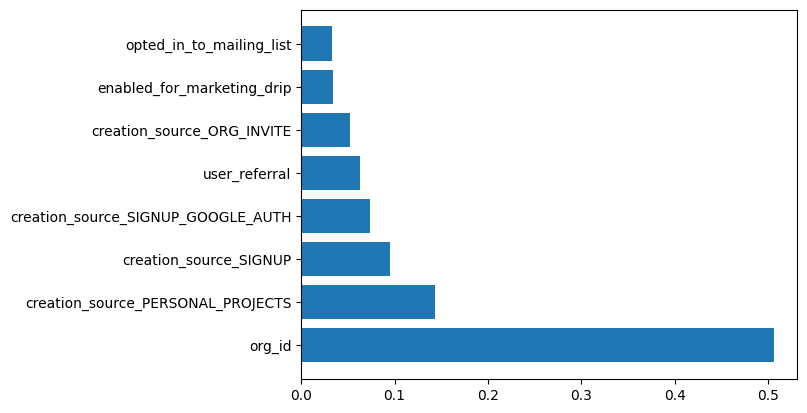

In [593]:
plt.barh(feature_imp_df['columns'],feature_imp_df.importance)
plt.plot()